In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# va por aca che
def make_timeline(sf, bw, spc):
    # sf: spreading factor
    # bw: bandwidth
    # spc: samples per chip
    symbol_time = (2**sf) / bw
    timeline =  np.linspace(0, symbol_time, (2**sf) * spc + 1)
    timeline = timeline[:-1]
    return timeline

In [3]:
def make_freq_evol(symbol, timeline, sf, bw):
    # bw: bandwidth
    theoretical_symbol_time = (2**sf) / bw
    slope = bw / (theoretical_symbol_time)
    y_intercept = symbol * (bw / 2**sf)
    frequency_evolution = []
    for i in range(len(timeline)):
        instant_freq = y_intercept + slope * timeline[i]
        if instant_freq > bw:
            instant_freq = instant_freq - bw
        frequency_evolution.append(instant_freq)
    
    return frequency_evolution

In [4]:
def compute_auxiliary_phase_factor(symbol, timeline, sf, bw):
    # bw: bandwidth
    theoretical_symbol_time = (2**sf) / bw
    slope = bw / (theoretical_symbol_time)
    y_intercept = symbol * (bw / 2**sf)
    integrated_freq = []
    for i in range(len(timeline)):
        instant_freq = y_intercept + 0.5 * slope * timeline[i]
        if instant_freq > bw:
            instant_freq = instant_freq - bw
        integrated_freq.append(instant_freq)
    
    return integrated_freq

In [5]:
def generate_signal(sf, freq, timeline, samples_per_symbol = 1):
    # sf: spreading factor
    # freq: frequency
    # timeline: timeline
    coeff = 1/(np.sqrt(2**sf * samples_per_symbol) )
    signal = []

    for i in range(len(timeline)):

        inst_phase = 2 * np.pi * freq[i] * timeline[i] 
        signal.append( coeff * np.exp(1j * inst_phase) )

    return signal

In [13]:
## Demodulation
# Generate downchirp
def generate_downchirp(sf, bw, timeline, also_return_freq=False, samples_per_chip = 1):
    # sf: spreading factor
    # freq: frequency
    # timeline: timeline
    y_intercept = bw
    theoretical_symbol_time = (2**sf) / bw
    freqs = []
    integrated_freqs = []
    slope = -bw / theoretical_symbol_time
    coeff = 1/(np.sqrt(2**sf * samples_per_chip) )
    signal = []

    for i in range(len(timeline)):
        freq = y_intercept + slope * timeline[i]
        integrated_freq = y_intercept + 0.5 * slope * timeline[i]

        inst_phase = 2 * np.pi * (integrated_freq) * timeline[i]
        signal.append( coeff * np.exp(1j * inst_phase))
        freqs.append(freq)
        

    if also_return_freq:
        return signal, freqs
    return signal

def correlate(signal, sf, downchirp, return_symbol=False):
    product = []
    for i in range(len(signal)):
        product.append(signal[i] * downchirp[i])

    fourier_transform = np.fft.fft(product)
    
    if return_symbol:
        return np.argmax(fourier_transform) % 2**sf
    
    
    return fourier_transform

In [7]:
def test_all(sf, bw, spc):
    symbols_sent = []
    symbols_received = []
    timeline_2 = make_timeline(sf, bw, spc)
    error_started_at = -1
    for i in range(2**sf):
        freq = make_freq_evol(i, timeline_2, sf, bw)
        signal = generate_signal(sf, freq, timeline_2)
        downchirp = generate_downchirp(sf, bw, timeline_2)
        correlation = correlate(signal,sf, downchirp, return_symbol=True)
        symbols_sent.append(i)
        symbols_received.append(correlation)
        if error_started_at == -1 and i != correlation:
            error_started_at = i
    return symbols_sent, symbols_received, error_started_at


In [8]:
from lora import LoraModulator, LoraDemodulator

spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 2
symbol_test = 65



lora_mod = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
lora_dem = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)

og_t, og_s, og_f =lora_mod.modulate_symbols([symbol_test], True)

new_f = make_freq_evol(symbol_test, og_t, spreading_factor, bandwidth)
new_s = generate_signal(spreading_factor, new_f, og_t)

# Modulation test
print("Frequency evolution is equal? ", og_f == new_f)
print("Signal is equal? ", og_s == new_s)

# Demodulation test
og_dchirp_t, og_dchirp_f, og_dchirp_s = lora_dem.generate_full_downchirp()
new_dchirp_s = generate_downchirp(spreading_factor, bandwidth, og_t)

print("Downchirp is equal? ", og_dchirp_s == new_dchirp_s)

og_correlation_fft = lora_dem.demodulate_symbol(og_s, True)
new_correlation_fft = correlate(new_s,spreading_factor, new_dchirp_s)

print("FFT Correlation is equal?", (og_correlation_fft == new_correlation_fft).all())

og_observed_symbol = lora_dem.demodulate_symbol(og_s, False)
new_observed_symbol = correlate(new_s, spreading_factor, new_dchirp_s, return_symbol=True)
print(new_observed_symbol)
print("Observed symbol is equal?", og_observed_symbol == new_observed_symbol)

print("Did both demodulate the correct symbol?", new_observed_symbol == symbol_test)



Frequency evolution is equal?  False
Signal is equal?  False
Downchirp is equal?  False
FFT Correlation is equal? False
110
Observed symbol is equal? False
Did both demodulate the correct symbol? False


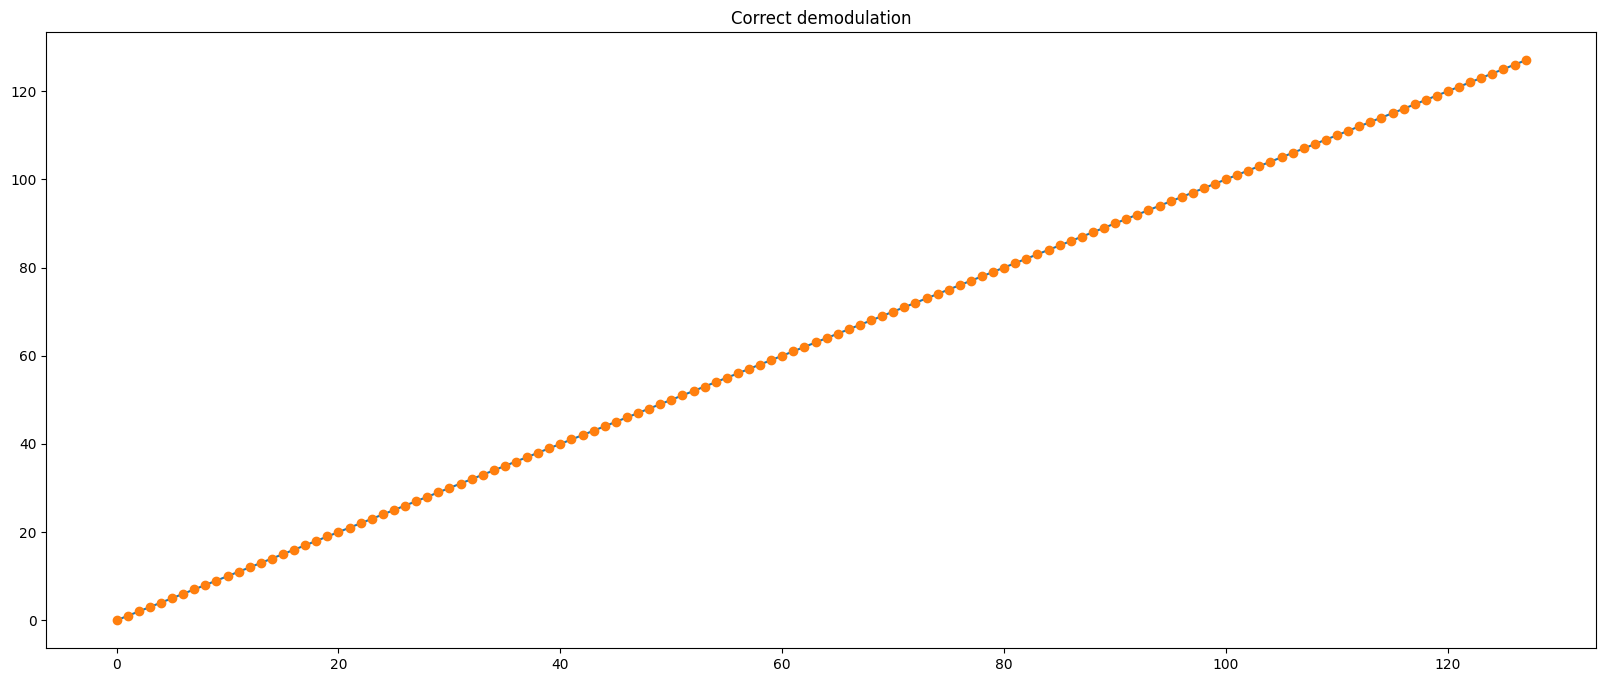

In [14]:
def test_all(sf, bw, t):

    symbols_sent = []
    symbols_received = []
    for i in range(2**sf):
        freq = make_freq_evol(i, t, sf, bw)
        int_freq = compute_auxiliary_phase_factor(i, t, sf, bw)
        signal = generate_signal(sf, int_freq, t)

        downchirp = generate_downchirp(sf, bw, t)
        correlation = correlate(signal,sf, downchirp, return_symbol=True)
        symbols_sent.append(i)
        symbols_received.append(correlation)
    return symbols_sent, symbols_received

spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 1
timeline = make_timeline(spreading_factor, bandwidth, samples_per_chip)
symbols_sent, symbols_received = test_all(spreading_factor, bandwidth, timeline)
plt.figure(figsize=(20,8))
plt.plot(symbols_sent, label="Sent")
plt.plot(symbols_received,'o', label="Received")
if symbols_sent == symbols_received:
    plt.title("Correct demodulation")





In [10]:
def signal_power(signal):
    # Calculate the signal power
    P = np.mean(np.abs(signal)**2)
    return P


def noise_generator(SNR, w):
    # Check if SNR is given in dB, DB, or db and convert if necessary
    if isinstance(SNR, str) and SNR.lower().endswith('db'):
        # Extract the numeric part and convert from dB to linear scale
        SNR_value = float(SNR[:-2])  # Remove the last two characters and convert to float
        SNR_linear = 10 ** (SNR_value / 10)
    else:
        # Assume SNR is already in linear scale
        SNR_linear = SNR
    
    # Determine the noise power (variance)
    variance = signal_power(w) / SNR_linear
    std_dev = variance ** 0.5
    # Generate noise
    N = [np.random.normal(0, std_dev) + np.random.normal(0, std_dev)*1j for _ in w]
    noisy_signal = [w[i] + N[i] for i in range(len(w))]
    return noisy_signal, N, variance

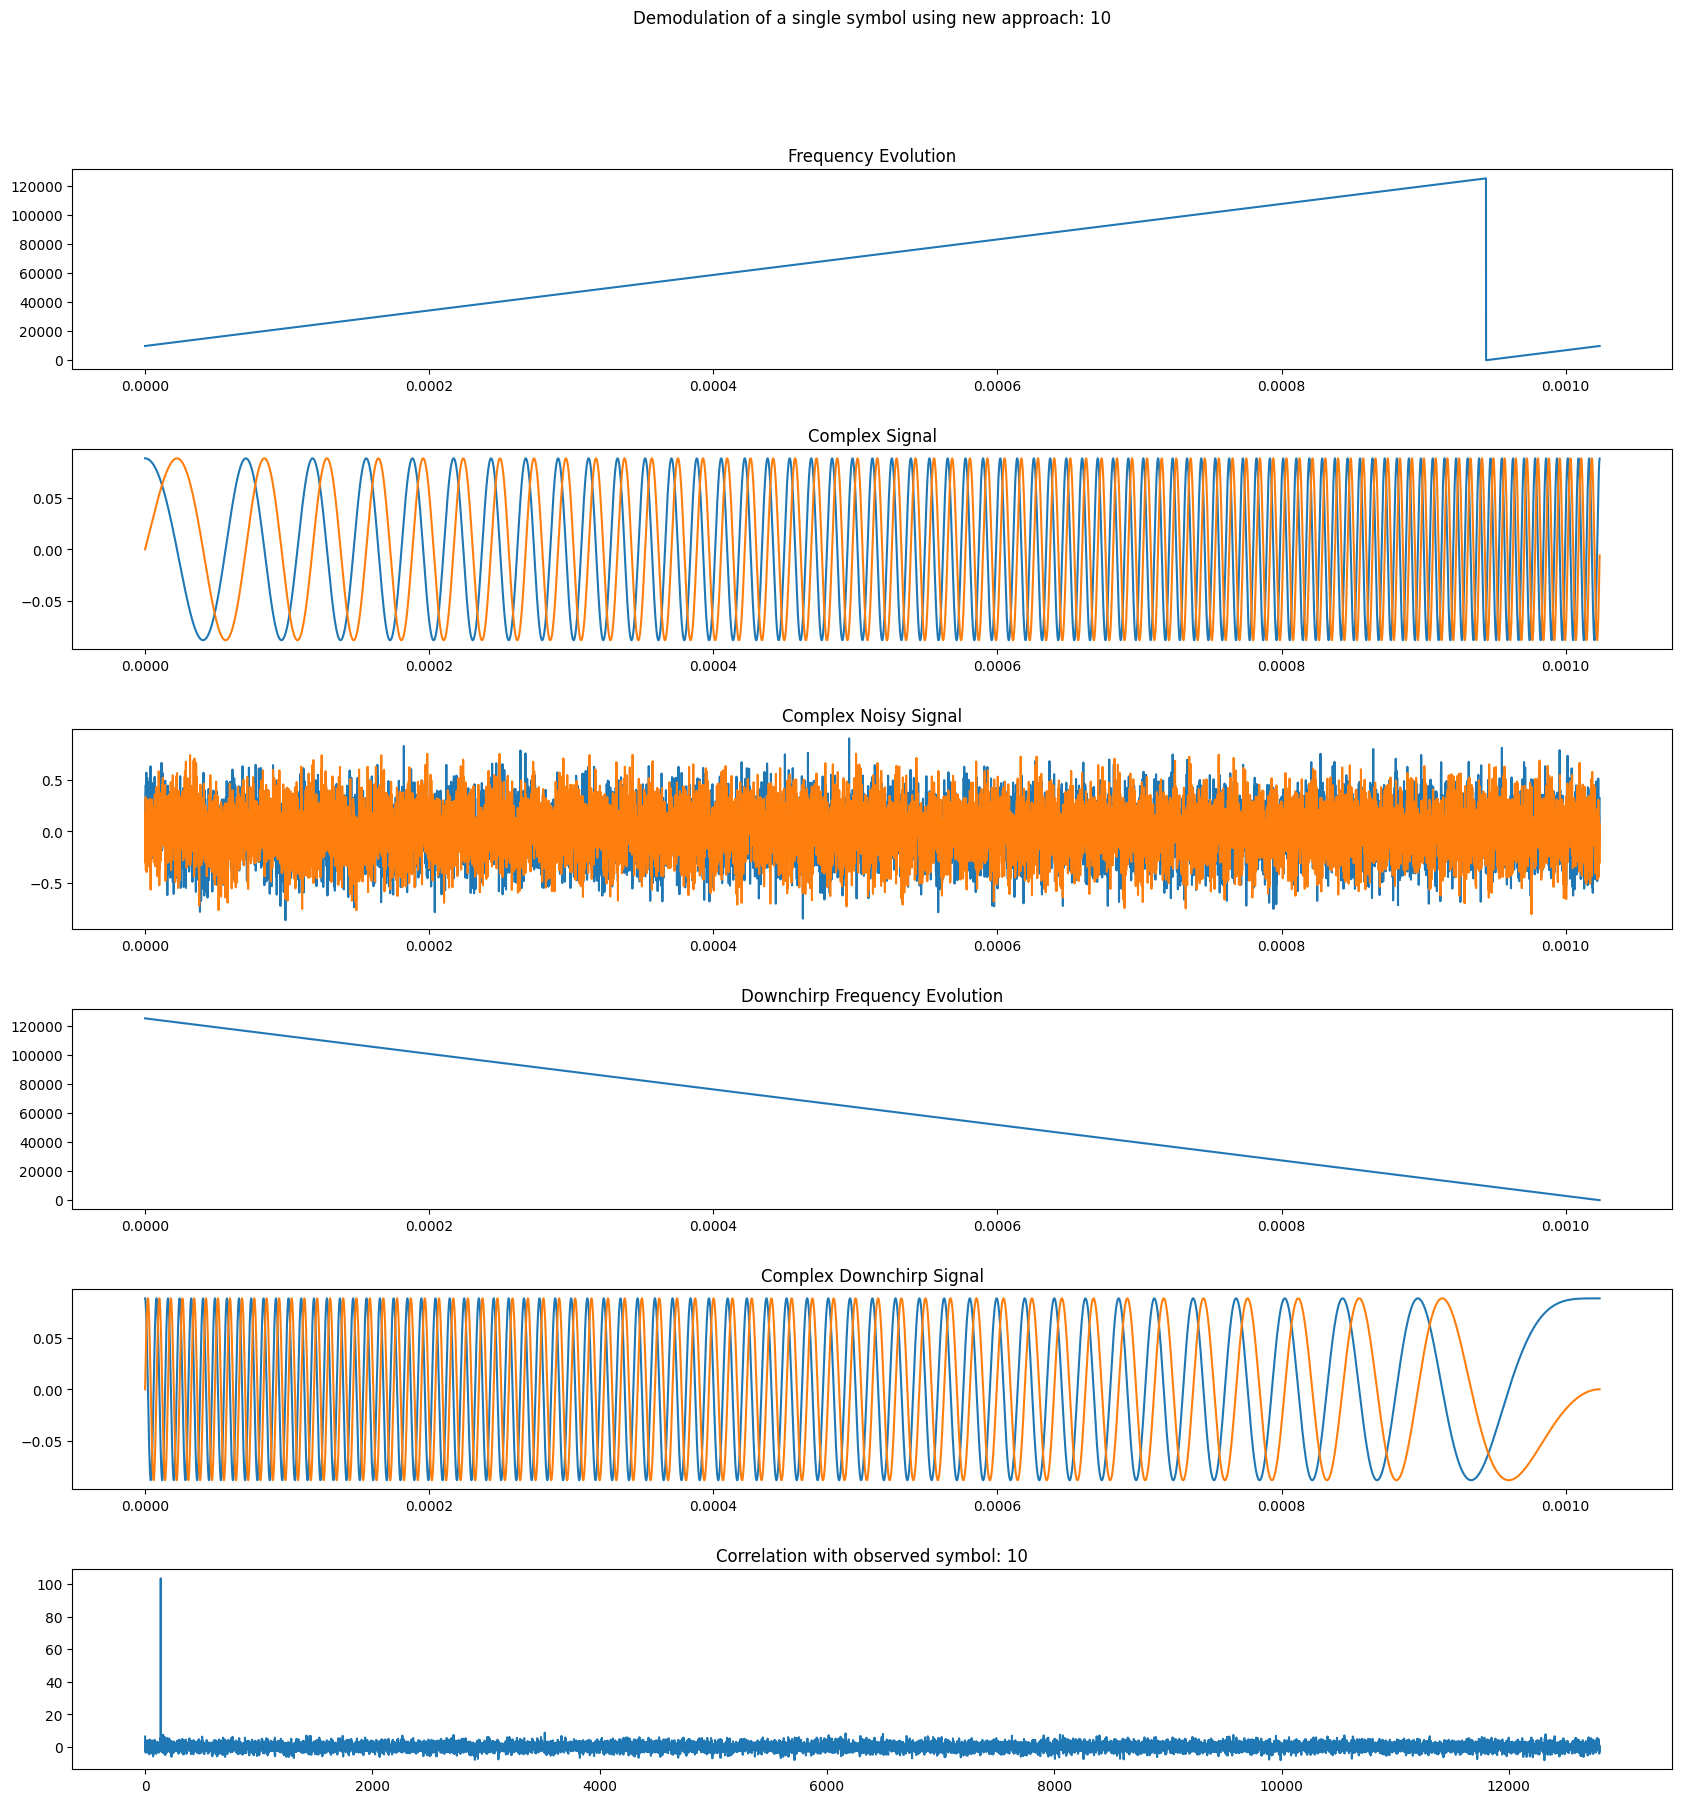

In [22]:
spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 100
symbol_to_transmit = 10
timeline = make_timeline(spreading_factor, bandwidth, samples_per_chip)
freq = make_freq_evol(symbol_to_transmit, timeline, spreading_factor, bandwidth)
int_freq = compute_auxiliary_phase_factor(symbol_to_transmit, timeline, spreading_factor, bandwidth)
signal = generate_signal(spreading_factor, int_freq, timeline)
downchirp, downchirp_freq = generate_downchirp(spreading_factor, bandwidth, timeline, also_return_freq=True)

noisy_signal = noise_generator("-8dB", signal)[0]

correlation = correlate(noisy_signal, spreading_factor, downchirp, return_symbol=False)
observed_symbol = correlate(noisy_signal, spreading_factor, downchirp, return_symbol=True)

fig, axs = plt.subplots(6,1, figsize=(20,20))

fig.suptitle("Demodulation of a single symbol using new approach: " + str(symbol_to_transmit))

axs[0].plot(timeline, freq, label="Frequency Evolution")
axs[0].set_title("Frequency Evolution")

axs[1].plot(timeline, np.real(signal), label="Real")
axs[1].plot(timeline, np.imag(signal), label="Imaginary")
axs[1].set_title("Complex Signal")

axs[2].plot(timeline, np.real(noisy_signal), label="Real Noisy Signal")
axs[2].plot(timeline, np.imag(noisy_signal), label="Imaginary Noisy Signal")
axs[2].set_title("Complex Noisy Signal")

axs[3].plot(timeline, downchirp_freq, label="Downchirp Frequency Evolution")
axs[3].set_title("Downchirp Frequency Evolution")

axs[4].plot(timeline, np.real(downchirp), label="Real Downchirp")
axs[4].plot(timeline, np.imag(downchirp), label="Imaginary Downchirp")
axs[4].set_title("Complex Downchirp Signal")

axs[5].plot(correlation, label="Correlation")
axs[5].set_title("Correlation with observed symbol: " + str(observed_symbol))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()



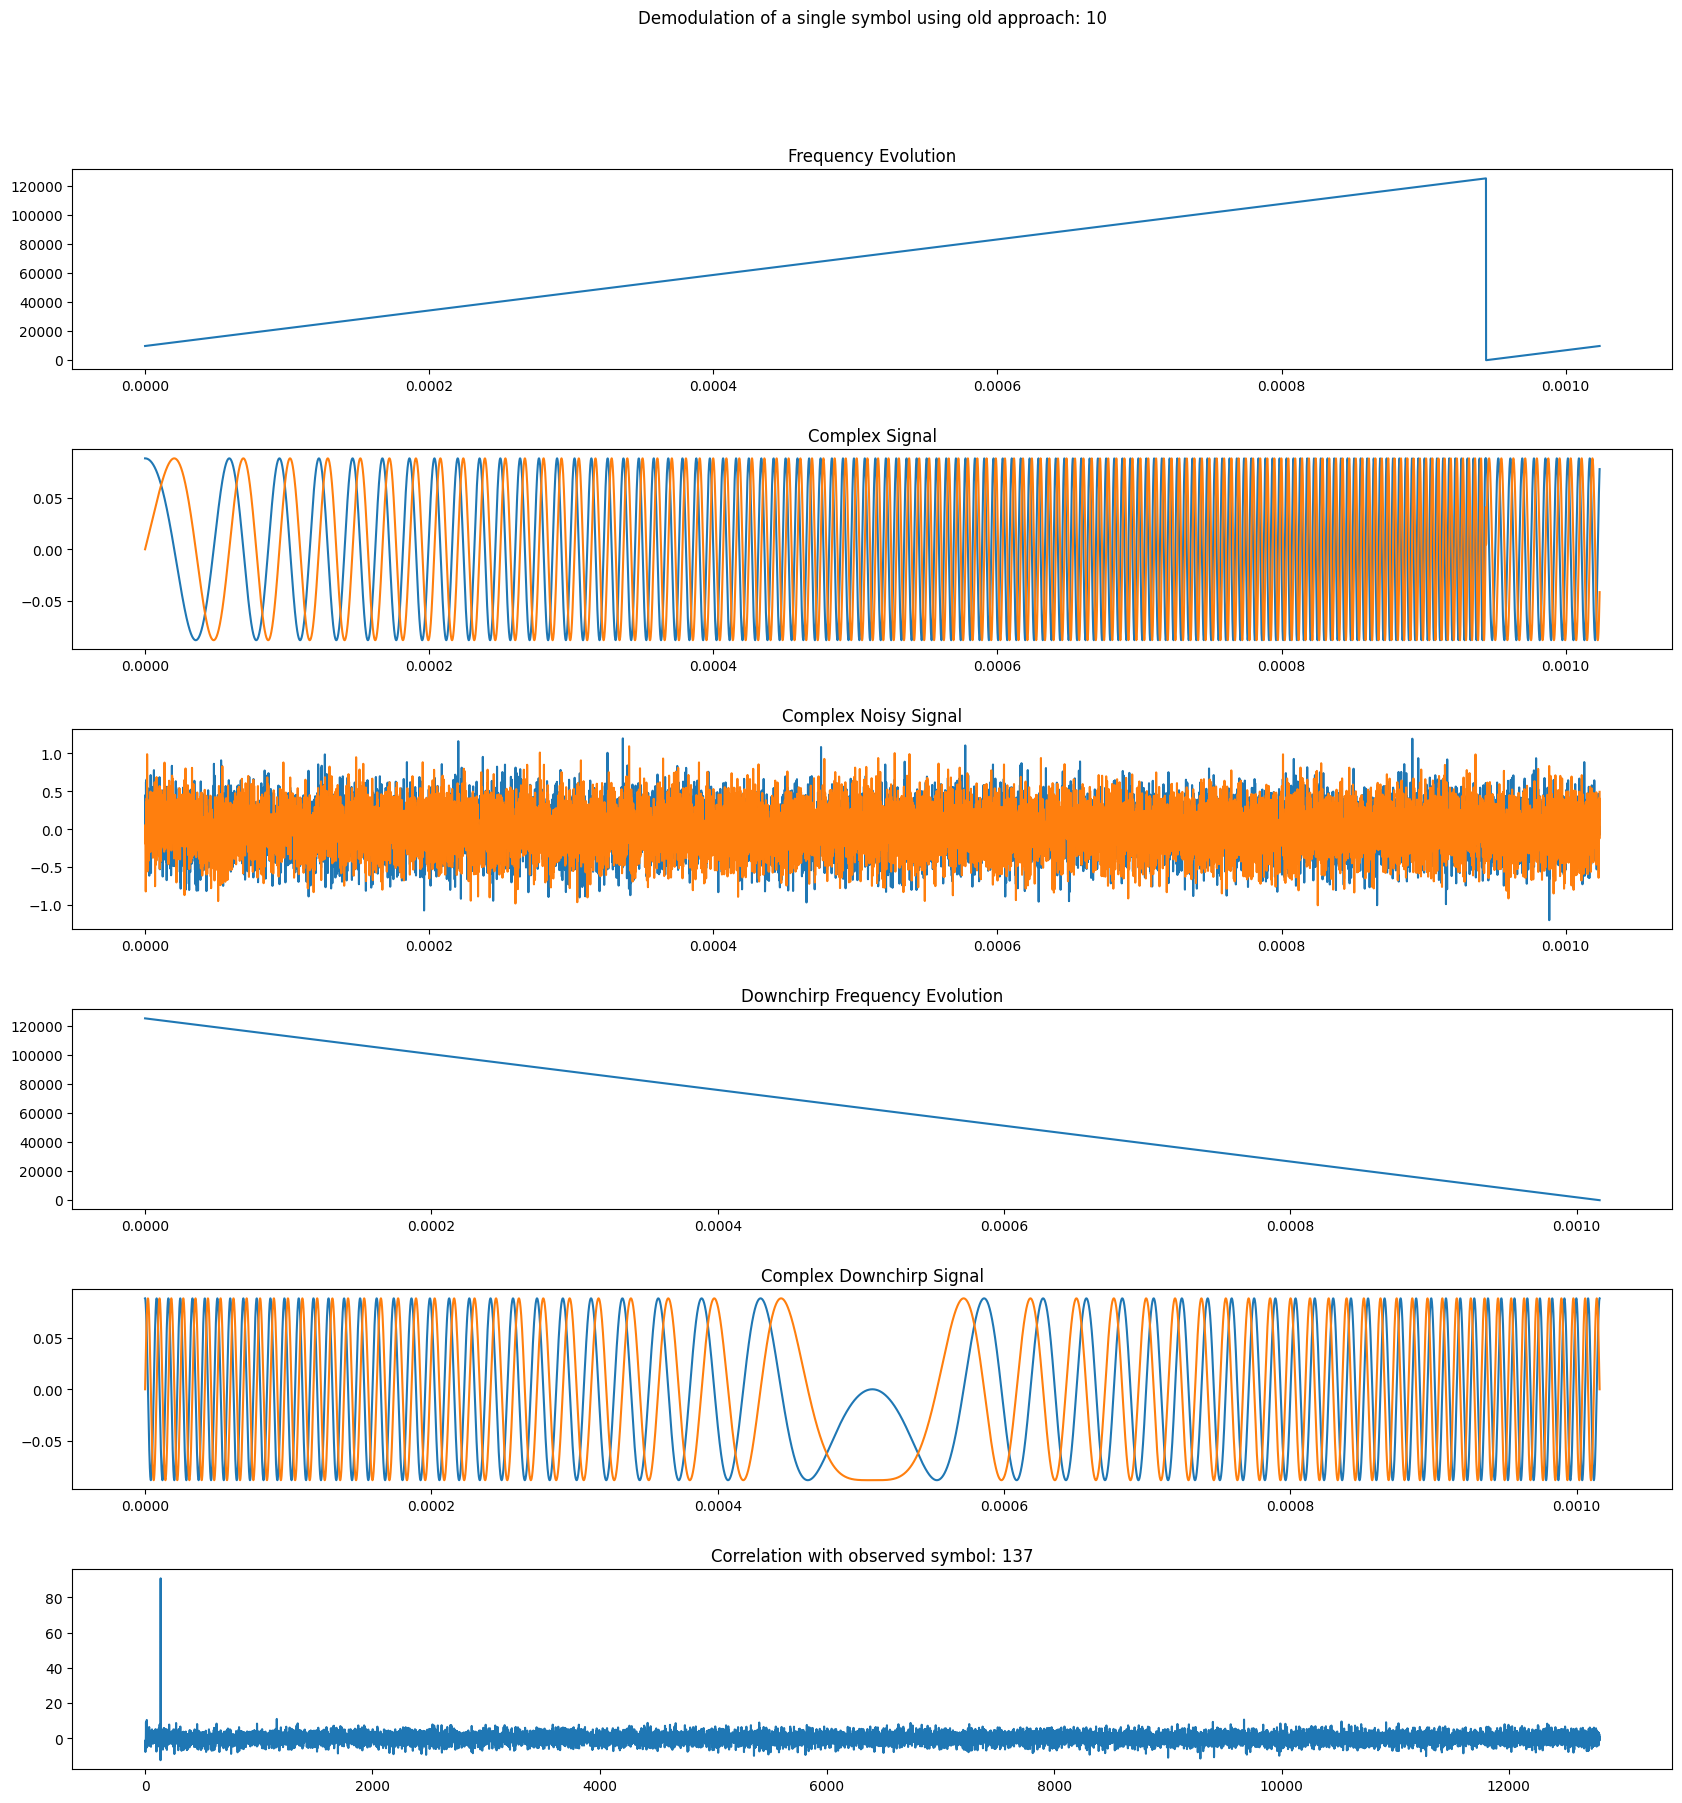

: 

In [23]:
from lora import LoraModulator, LoraDemodulator

lora_mod = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
lora_dem = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
t, s, f = lora_mod.modulate_symbols([symbol_to_transmit], True)
n_s = noise_generator("-10dB", s)[0]
dchirp_t, dchirp_f, dchirp_s = lora_dem.generate_full_downchirp()
correlation_fft = lora_dem.demodulate_symbol(n_s, True)
observed_sym = lora_dem.demodulate_symbol(n_s, False)


fig2, axs2 = plt.subplots(6,1, figsize=(20,20))
fig2.suptitle("Demodulation of a single symbol using old approach: " + str(symbol_to_transmit))

axs2[0].plot(timeline, f, label="Frequency Evolution")
axs2[0].set_title("Frequency Evolution")

axs2[1].plot(timeline, np.real(s), label="Real")
axs2[1].plot(timeline, np.imag(s), label="Imaginary")
axs2[1].set_title("Complex Signal")

axs2[2].plot(timeline, np.real(n_s), label="Real Noisy Signal")
axs2[2].plot(timeline, np.imag(n_s), label="Imaginary Noisy Signal")
axs2[2].set_title("Complex Noisy Signal")

axs2[3].plot(dchirp_t, dchirp_f, label="Downchirp Frequency Evolution")
axs2[3].set_title("Downchirp Frequency Evolution")

axs2[4].plot(dchirp_t, np.real(dchirp_s), label="Real Downchirp")
axs2[4].plot(dchirp_t, np.imag(dchirp_s), label="Imaginary Downchirp")
axs2[4].set_title("Complex Downchirp Signal")

axs2[5].plot(correlation_fft, label="Correlation")
axs2[5].set_title("Correlation with observed symbol: " + str(observed_sym))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()